In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv1D,MaxPooling1D,Dropout,BatchNormalization
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [47]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,roc_curve,auc,roc_auc_score

In [40]:
"From kaggle competition evaluation metrix"
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d),g,d

In [3]:
final_data=pd.read_csv('Final_Data.csv')
req=final_data.columns
req=req[1:-1]
target=final_data['target']
data_x=final_data[req]
train_x,test_x,train_y,test_y=train_test_split(data_x,target,test_size=0.2)

In [5]:
train_x=train_x.to_numpy()
test_x=test_x.to_numpy()
train_y=train_y.to_numpy()
test_y=test_y.to_numpy()
train_x=train_x.reshape(train_x.shape[0],train_x.shape[1],1)
test_x=test_x.reshape(test_x.shape[0],test_x.shape[1],1)
print(train_x.shape)
print(test_x.shape)

(79784, 84, 1)
(19946, 84, 1)


In [28]:
model=Sequential()
model.add(Conv1D(64,2,activation='relu',padding='same',input_shape=train_x[0].shape))
model.add(Conv1D(64,2,activation='relu',padding='same'))
model.add(MaxPooling1D(pool_size=(2),strides=(2),padding='valid'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(32,2,activation='relu',padding='same'))
model.add(MaxPooling1D(pool_size=(2),strides=(2),padding='valid'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 84, 64)            192       
                                                                 
 conv1d_16 (Conv1D)          (None, 84, 64)            8256      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 42, 64)           0         
 g1D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 42, 64)           256       
 chNormalization)                                                
                                                                 
 conv1d_17 (Conv1D)          (None, 42, 32)            4128      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 21, 32)          

In [29]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'])

model.fit(train_x,train_y,epochs=10,validation_data=(test_x,test_y),verbose=1)

Epoch 1/10
2494/2494 [==============================] - 22s 8ms/step - loss: 0.3143 - accuracy: 0.8550 - val_loss: 0.3062 - val_accuracy: 0.8564
Epoch 2/10
2494/2494 [==============================] - 20s 8ms/step - loss: 0.3033 - accuracy: 0.8614 - val_loss: 0.2995 - val_accuracy: 0.8597
Epoch 3/10
2494/2494 [==============================] - 20s 8ms/step - loss: 0.2987 - accuracy: 0.8633 - val_loss: 0.2994 - val_accuracy: 0.8587
Epoch 4/10
2494/2494 [==============================] - 20s 8ms/step - loss: 0.2960 - accuracy: 0.8645 - val_loss: 0.3049 - val_accuracy: 0.8571
Epoch 5/10
2494/2494 [==============================] - 20s 8ms/step - loss: 0.2944 - accuracy: 0.8662 - val_loss: 0.3047 - val_accuracy: 0.8579
Epoch 6/10
2494/2494 [==============================] - 20s 8ms/step - loss: 0.2915 - accuracy: 0.8673 - val_loss: 0.3053 - val_accuracy: 0.8554
Epoch 7/10
2494/2494 [==============================] - 22s 9ms/step - loss: 0.2886 - accuracy: 0.8707 - val_loss: 0.3078 - val_ac

In [51]:
pred_proba_y=model.predict(test_x)

624/624 [==============================] - 1s 2ms/step


In [52]:
def predictor(x):
    if x>0.5:
        return 1
    else:
        return 0
pred_y=np.array([predictor(i) for i in pred_proba_y])

In [53]:
import matplotlib.pyplot as plt

The Accuracy Score is 0.8596711120024065
The Precision is 0.716457235508715
The recall is 0.7163120567375887
The f1 score is 0.716384638767859
The area under curve 0.9167693370690604


Text(0.5, 1.0, 'ROC Curve')

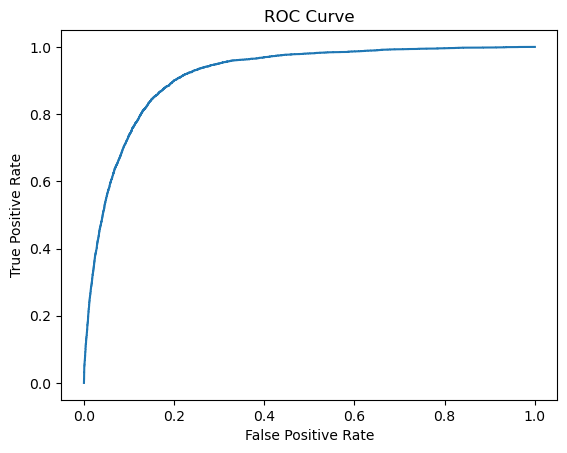

In [54]:
print("The Accuracy Score is {}".format(accuracy_score(pred_y,test_y)))
pre_recall_f1=precision_recall_fscore_support(test_y,pred_y,average='binary')
print("The Precision is {}".format(pre_recall_f1[0]))
print("The recall is {}".format(pre_recall_f1[1]))
print("The f1 score is {}".format(pre_recall_f1[2]))
fpr, tpr, thresholds_roc = roc_curve(test_y,pred_proba_y)
roc_auc = auc(fpr,tpr)
print("The area under curve {}".format(roc_auc))
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [57]:
test_y_num=np.array(test_y)
df=pd.DataFrame(test_y_num,columns=['target'])
df2=pd.DataFrame(pred_proba_y,columns=['prediction'])

In [58]:
gd,g,d=amex_metric(df,df2)
print("Gini coefficient {}".format(g))
print("Top 4% capture {}".format(d))
print("Final eval metric {}".format(gd))

Gini coefficient 0.8335283090379694
Top 4% capture 0.44356636271529887
Final eval metric 0.6385473358766341


In [31]:
final_data=pd.read_csv('Final_Data_new.csv')
req=final_data.columns
req=req[2:-1]
target=final_data['target']
data_x=final_data[req]
train_x,test_x,train_y,test_y=train_test_split(data_x,target,test_size=0.2)

In [32]:
train_x=train_x.to_numpy()
test_x=test_x.to_numpy()
train_y=train_y.to_numpy()
test_y=test_y.to_numpy()
train_x=train_x.reshape(train_x.shape[0],train_x.shape[1],1)
test_x=test_x.reshape(test_x.shape[0],test_x.shape[1],1)
print(train_x.shape)
print(test_x.shape)

(79784, 84, 1)
(19946, 84, 1)


In [33]:
model=Sequential()
model.add(Conv1D(64,2,activation='relu',padding='same',input_shape=train_x[0].shape))
model.add(Conv1D(64,2,activation='relu',padding='same'))
model.add(MaxPooling1D(pool_size=(2),strides=(2),padding='valid'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(32,2,activation='relu',padding='same'))
model.add(MaxPooling1D(pool_size=(2),strides=(2),padding='valid'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 84, 64)            192       
                                                                 
 conv1d_19 (Conv1D)          (None, 84, 64)            8256      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 42, 64)           0         
 g1D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 42, 64)           256       
 chNormalization)                                                
                                                                 
 conv1d_20 (Conv1D)          (None, 42, 32)            4128      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 21, 32)          

In [34]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_x,train_y,epochs=10,validation_data=(test_x,test_y),verbose=1)

Epoch 1/10
2494/2494 [==============================] - 24s 9ms/step - loss: 0.3137 - accuracy: 0.8552 - val_loss: 0.3207 - val_accuracy: 0.8571
Epoch 2/10
2494/2494 [==============================] - 22s 9ms/step - loss: 0.3034 - accuracy: 0.8613 - val_loss: 0.3098 - val_accuracy: 0.8606
Epoch 3/10
2494/2494 [==============================] - 23s 9ms/step - loss: 0.3004 - accuracy: 0.8634 - val_loss: 0.3072 - val_accuracy: 0.8562
Epoch 4/10
2494/2494 [==============================] - 24s 10ms/step - loss: 0.2988 - accuracy: 0.8635 - val_loss: 0.3061 - val_accuracy: 0.8608
Epoch 5/10
2494/2494 [==============================] - 24s 10ms/step - loss: 0.2953 - accuracy: 0.8661 - val_loss: 0.3057 - val_accuracy: 0.8568
Epoch 6/10
2494/2494 [==============================] - 22s 9ms/step - loss: 0.2938 - accuracy: 0.8667 - val_loss: 0.3066 - val_accuracy: 0.8614
Epoch 7/10
2494/2494 [==============================] - 21s 8ms/step - loss: 0.2909 - accuracy: 0.8685 - val_loss: 0.3064 - val_

In [37]:
pred_proba_y=model.predict(test_x)

624/624 [==============================] - 1s 2ms/step


In [45]:
def predictor(x):
    if x>0.5:
        return 1
    else:
        return 0
pred_y=np.array([predictor(i) for i in pred_proba_y])

The Accuracy Score is 0.8596711120024065
The Precision is 0.716457235508715
The recall is 0.7163120567375887
The f1 score is 0.716384638767859
The area under curve 0.9167693370690604


Text(0.5, 1.0, 'ROC Curve')

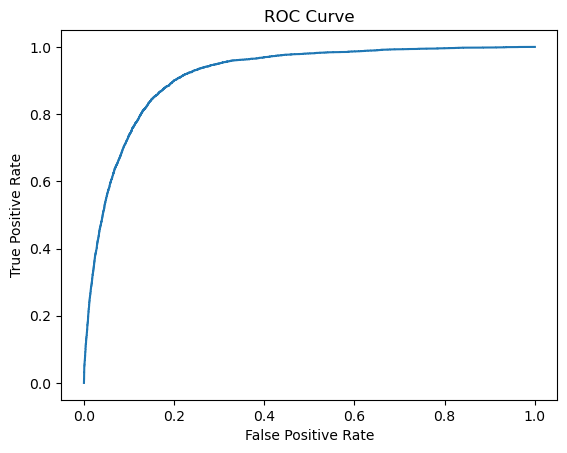

In [49]:
print("The Accuracy Score is {}".format(accuracy_score(pred_y,test_y)))
pre_recall_f1=precision_recall_fscore_support(test_y,pred_y,average='binary')
print("The Precision is {}".format(pre_recall_f1[0]))
print("The recall is {}".format(pre_recall_f1[1]))
print("The f1 score is {}".format(pre_recall_f1[2]))
fpr, tpr, thresholds_roc = roc_curve(test_y,pred_proba_y)
roc_auc = auc(fpr,tpr)
print("The area under curve {}".format(roc_auc))
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [42]:
test_y_num=np.array(test_y)
df=pd.DataFrame(test_y_num,columns=['target'])
df2=pd.DataFrame(pred_proba_y,columns=['prediction'])

In [43]:
gd,g,d=amex_metric(df,df2)
print("Gini coefficient {}".format(g))
print("Top 4% capture {}".format(d))
print("Final eval metric {}".format(gd))

Gini coefficient 0.8335283090379694
Top 4% capture 0.44356636271529887
Final eval metric 0.6385473358766341
